In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import misc
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers.convolutional import Conv2D
from keras.layers import *
from keras import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
%matplotlib nbagg
from keras.utils import np_utils
from keras import backend as K
import cv2
from sklearn.model_selection import train_test_split
K.set_image_dim_ordering('th')
%matplotlib 

Using matplotlib backend: TkAgg


In [ ]:
img_height, img_width = 480,640
from keras.preprocessing import image
from itertools import izip

batch_size = 100
def hot_vectorize(x):
    zero_mask = x==0
    non_zero_mask = x!=0
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x

def combine_data_generators(depth,normal,rgb,mask):
    while True:
            d = depth.next()
            n = normal.next()
            r = rgb.next()
            m = mask.next()
            yield (np.concatenate((d,n,r),2),m)
            
labeldatagen = image.ImageDataGenerator(
        #preprocessing_function=applications.xception.preprocess_input,
        #preprocessing_function = random_crop,
        #zoom_range=.5,plt.figure()
        preprocessing_function = hot_vectorize,
        data_format="channels_last")

datagen = image.ImageDataGenerator(
        #preprocessing_function=applications.xception.preprocess_input,
        #preprocessing_function = random_crop,
        rescale =1/255.,
        #zoom_range=.5,
        data_format="channels_last")

flow_from_directory_params_grey = {'target_size': (img_height,img_width),
                                  'color_mode': 'grayscale',
                                  'class_mode': None,
                                  'batch_size': batch_size}

flow_from_directory_params_color = {'target_size': (img_height,img_width),
                                  'color_mode': 'rgb',
                                  'class_mode': None,
                                  'batch_size': batch_size}


mask_generator = labeldatagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/depth",
        shuffle = False,
        **flow_from_directory_params_grey
    )
rgb_generator = datagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/rgb",
        shuffle = False,
        **flow_from_directory_params_color
    )
normal_generator = datagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/normal",
        shuffle = False,
        **flow_from_directory_params_color
    )
gt_generator = datagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/gtdepth",
        shuffle =False,
        **flow_from_directory_params_grey
    )


train_generator = combine_data_generators(gt_generator,normal_generator,rgb_generator,mask_generator)
np.shape(train_generator.next())

Found 117661 images belonging to 1 classes.


In [366]:
inputs = Input((3,img_height, img_width))
keras.layers.Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)

In [367]:
conv1 = Conv2D(6, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(inputs)
conv1 = Conv2D(6, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(conv1)

conv2 = Conv2D(12, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(pool1)
conv2 = Conv2D(12, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(conv2)

conv3 = Conv2D(24, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(pool2)
conv3 = Conv2D(24, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(conv3)

conv4 = Conv2D(48, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(pool3)
conv4 = Conv2D(48, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(drop4)

conv5 = Conv2D(96, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(pool4)
conv5 = Conv2D(96, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(48, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(UpSampling2D(size = (2,2))(drop5))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 0)
conv6 = Conv2D(48, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(merge6)
conv6 = Conv2D(48, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv6)

up7 = Conv2D(24, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 0)
conv7 = Conv2D(24, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(merge7)
conv7 = Conv2D(24, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv7)

up8 = Conv2D(12, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 0)
conv8 = Conv2D(12, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(merge8)
conv8 = Conv2D(12, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv8)

up9 = Conv2D(6, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 0)
conv9 = Conv2D(6, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(merge9)
conv9 = Conv2D(6, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_first')(conv9)

model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 3, 480, 640)  0                                            
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 6, 480, 640)  168         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 6, 480, 640)  330         conv2d_139[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 6, 240, 320)  0           conv2d_140[0][0]                 
__________________________________________________________________________________________________
conv2d_141

In [368]:
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
print('Fitting model...')
model.fit_generator(train_generator, nb_epoch=100,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<itertools..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=100, callbacks=[<keras.ca...)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6897 - acc: 0.8310
Epoch 00001: loss improved from inf to 0.68970, saving model to unet.hdf5
100/100 [==============================] - 13s 133ms/step - loss: 0.6897 - acc: 0.8311
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6667 - acc: 0.8668
Epoch 00002: loss improved from 0.68970 to 0.66663, saving model to unet.hdf5
100/100 [==============================] - 10s 98ms/step - loss: 0.6666 - acc: 0.8669
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6456 - acc: 0.8775- ETA: 0s - loss: 0.6462 - acc: 0.
Epoch 00003: loss improved from 0.66663 to 0.64546, saving model to unet.hdf5
100/100 [==============================] - 10s 99ms/step - loss: 0.6455 - acc: 0.8776
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6235 - acc: 0.8868
Epoch 00004: loss improved from 0.64546 to 0.62343, saving model to unet.hdf5
100/100 [======================

Epoch 70/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2479 - acc: 0.9035
Epoch 00070: loss did not improve
100/100 [==============================] - 10s 102ms/step - loss: 0.2479 - acc: 0.9035
Epoch 71/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2420 - acc: 0.9054
Epoch 00071: loss did not improve
100/100 [==============================] - 10s 102ms/step - loss: 0.2420 - acc: 0.9055
Epoch 72/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2360 - acc: 0.9109
Epoch 00072: loss did not improve
100/100 [==============================] - 10s 102ms/step - loss: 0.2360 - acc: 0.9109
Epoch 73/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2294 - acc: 0.9132
Epoch 00073: loss did not improve
100/100 [==============================] - 10s 102ms/step - loss: 0.2295 - acc: 0.9132
Epoch 74/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2511 - acc: 0.9047
Epoch 00074: loss did not improve
100/100 [========

In [391]:
test = train_generator.next()
X_Test = test[0][0:10]
Y_Test = test[1][0:10]
imgs_mask_test = model.predict_on_batch(X_Test)

<IPython.core.display.Javascript object>


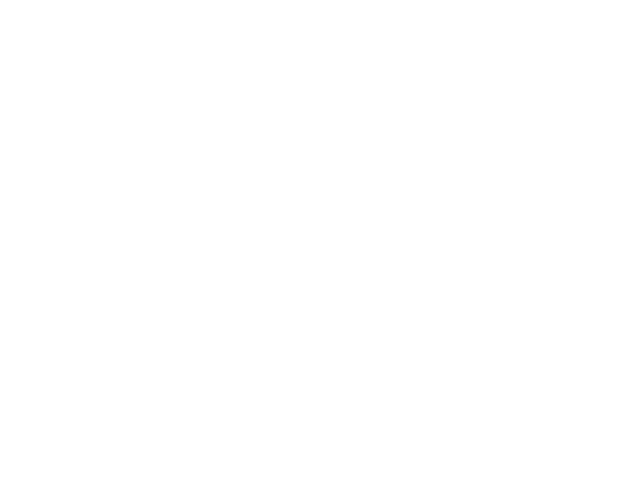

In [393]:
%matplotlib nbagg
index = np.random.randint(3)
img = np.reshape(imgs_mask_test[4],(img_height,img_width))
plt.imshow(img)

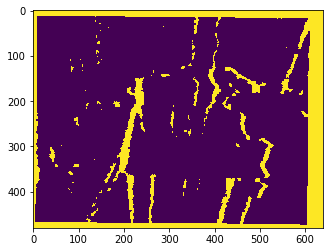

In [388]:
%matplotlib inline
img = np.reshape(Y_Test[0],(img_height,img_width))
plt.imshow(img)

In [169]:
train = train_generator.next()
X = train[0]
Y = train[1]
inputs = Input((1,img_height, img_width))

In [171]:
conv1 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(inputs)

conv2 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv1)

conv3 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv2)

conv4 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv3)
#drop4 = Dropout(0.5)(conv4)

conv5 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv4)

conv6 = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv5)
#drop5 = Dropout(0.5)(conv5)

model1 = Model(input = inputs, output = conv6)
print model1.summary()
model1.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 480, 640)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 480, 640)      832       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 64, 480, 640)      51264     
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 32, 480, 640)      51232     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 16, 480, 640)      4624      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 4, 480, 640)       580       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 1, 480, 640)       37        
Total para

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app


In [217]:
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
print('Fitting model...')
model1.fit_generator(train_generator, steps_per_epoch=100,nb_epoch=10, verbose=1, shuffle=True, callbacks=[model_checkpoint])

Fitting model...
Epoch 1/10
  1/100 [..............................] - ETA: 13s - loss: 0.3969 - acc: 0.8304

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<itertools..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=10, callbacks=[<keras.ca...)`
  This is separate from the ipykernel package so we can avoid doing imports until


 99/100 [============================>.] - ETA: 0s - loss: 0.3890 - acc: 0.8321
Epoch 00001: loss improved from inf to 0.38894, saving model to unet.hdf5
100/100 [==============================] - 10s 100ms/step - loss: 0.3889 - acc: 0.8322
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3845 - acc: 0.8345
Epoch 00002: loss improved from 0.38894 to 0.38439, saving model to unet.hdf5
100/100 [==============================] - 10s 97ms/step - loss: 0.3844 - acc: 0.8345
Epoch 3/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3850 - acc: 0.8282
Epoch 00003: loss did not improve
100/100 [==============================] - 10s 97ms/step - loss: 0.3851 - acc: 0.8281
Epoch 4/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3777 - acc: 0.8301
Epoch 00004: loss improved from 0.38439 to 0.37768, saving model to unet.hdf5
100/100 [==============================] - 10s 98ms/step - loss: 0.3777 - acc: 0.8301
Epoch 5/10
 99/100 [==================

In [229]:
test = train_generator.next()
X_Test = test[0][0:50]
Y_Test = test[1][0:50]

In [232]:
np.shape(X_Test),np.shape(imgs_mask_test)

((1, 1, 480, 640), (1, 1, 480, 640))

In [236]:
imgs_mask_test = model1.predict_on_batch(X_Test)

In [284]:
%matplotlib inline

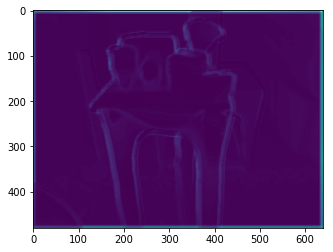

In [242]:
index = np.random.randint(10)
img = np.reshape(imgs_mask_test,(img_height,img_width))
plt.imshow(img)